<font size='5'><h1 >VGG19</h1></font>

## **Data preprocessing and exploring**

### Access Files in Drive

In [1]:
from google.colab import drive 
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


### Import required libraries and necessary packages

In [3]:
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import time


import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import img_to_array
from keras_preprocessing.image import load_img
from keras.applications import VGG16
from keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import np_utils, to_categorical
from sklearn.datasets import load_files
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix

### Load The data

In [4]:
# The path of our data on drive
data_dir =  r'/gdrive/My Drive/DataFolder'
 
# Loading Data
data = load_files(data_dir)

In [5]:
folders=os.listdir("/gdrive/My Drive/DataFolder")
print(folders)

['No_findings', 'Covid-19']


In [6]:
#Convert the data and labels to Numpy arrays
X = np.array(data['filenames'])
y = np.array(data['target'])
labels = np.array(data['target_names'])
 
# How the arrays look like?
print('Data files - ',X[0])
print('Target labels - ',y[0])
print('Number of training files : ', X.shape[0])
print('Number of training targets : ', y.shape[0])

Data files -  /gdrive/My Drive/DataFolder/No_findings/00002550_000.png
Target labels -  1
Number of training files :  625
Number of training targets :  625


### Convert images to arrays

In [7]:
def convert_img_to_arr(file_path_list):
    arr = []
    img_width, img_height = 224,224 
    #Loop over the image paths
    for file_path in file_path_list:
        """
           Load the image, swap color channels, and resize it to be a fixed
           224*224 pixels while ignoring aspect ratio
        """
        img = load_img(file_path, target_size = (img_width, img_height))
        img = img_to_array(img)
        
        #update the data
        arr.append(img)
    return arr
# Here our data is updated and it's stocked in the X array again !
X = np.array(convert_img_to_arr(X))

# The Data Shape
print(X.shape) 
print('First training item : ',X[0])

(625, 224, 224, 3)
First training item :  [[[35. 35. 35.]
  [32. 32. 32.]
  [26. 26. 26.]
  ...
  [22. 22. 22.]
  [23. 23. 23.]
  [22. 22. 22.]]

 [[30. 30. 30.]
  [26. 26. 26.]
  [26. 26. 26.]
  ...
  [22. 22. 22.]
  [23. 23. 23.]
  [23. 23. 23.]]

 [[22. 22. 22.]
  [22. 22. 22.]
  [24. 24. 24.]
  ...
  [22. 22. 22.]
  [23. 23. 23.]
  [22. 22. 22.]]

 ...

 [[24. 24. 24.]
  [27. 27. 27.]
  [55. 55. 55.]
  ...
  [67. 67. 67.]
  [78. 78. 78.]
  [78. 78. 78.]]

 [[21. 21. 21.]
  [25. 25. 25.]
  [41. 41. 41.]
  ...
  [76. 76. 76.]
  [82. 82. 82.]
  [78. 78. 78.]]

 [[21. 21. 21.]
  [30. 30. 30.]
  [25. 25. 25.]
  ...
  [77. 77. 77.]
  [81. 81. 81.]
  [73. 73. 73.]]]


#### **Few Take Aways**
#### Note that the shape of training data is **(625, 224, 224, 3)**
#####  
 
-   **625** is the **number** of training items or files,
-   **(224,224)** is the **target size** or image size provided while loading image
-   **3** refers to the **depth** for colored images ( RGB channels ).

### Take a look at some pictures

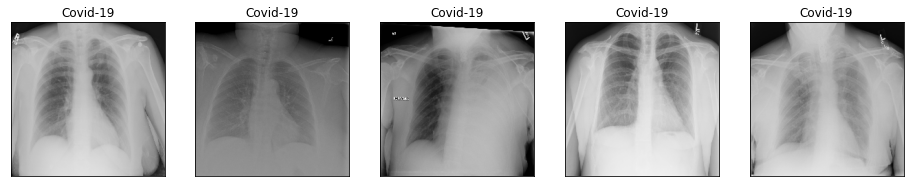

In [8]:
#Let's look at first 5 training data. 
fig = plt.figure(figsize = (16,9))
for i in range(5):
    ax = fig.add_subplot(1,5,i+1,xticks=[],yticks=[])
    ax.imshow((X[i].astype(np.uint8)))
    plt.title(folders[y[i]])

> **rescale value** is a value by which we will multiply the data before any other processing. Our original images consist in RGB coefficients in the 0-255, but such values would be too high for our models to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255. factor. So all values in X will lie within 0 to 1 !

In [9]:
"""
   After that data is converted into Numpy array, Now, 
   Let's scale the pixel intenties to the range[0,255]
"""
X = X.astype('float32')/255

# Let's confirm the number of classes :) 
no_of_classes = len(np.unique(y))
no_of_classes

2

In [10]:
y

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,

 ### Let's converts a class vector (integers) to binary class matrix

In [11]:
""" 
let's converts a class vector (integers) to binary class matrix by performing the 
one-hot encoding on the labels
"""
y = np.array(np_utils.to_categorical(y,no_of_classes))
y[0]

array([0., 1.], dtype=float32)

### Split the data into train, test and valid subsets
> Here we are going to split our dataset into **80% train**, **10% validation**, and **10% test**.

In [12]:
# let's splite the data into subsets and explore their shapes !

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
print('The train Data Shape ', X_train.shape[0])
 
X_test, X_valid, y_test, y_valid = train_test_split(X_test,y_test, test_size = 0.5)
print('The validation Data Shape ', X_valid.shape[0])
print('The test Data Shape ', X_test.shape[0])

The train Data Shape  500
The validation Data Shape  63
The test Data Shape  62


In [13]:
print('The train Data Shape ', X_train.shape[1:])

The train Data Shape  (224, 224, 3)


> **(224, 224, 3)** refers to the shape of the data (images) that will be fed into our CNN

---

### **CNN Implementation**

### Fine tuning VGG19 pre-trained model
>Here we are going to use Transfer Learning with advanced and popular VGG19 architecture with pre-trained weights on the popular **ImageNet** dataset. Then adapt it to our dataset. So, it will be our base Model

In [14]:
VGG19_model = keras.applications.VGG19(input_shape= X_train.shape[1:], include_top=False, weights="imagenet")
# setting the VGG model to be untrainable.
VGG19_model.trainable = False

80134624/80134624 [==============================] - 4s 0us/step


In [15]:
VGG19_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [16]:
from keras.layers import BatchNormalization
Model = Sequential()
Model.add(VGG19_model)
Model.add(BatchNormalization())
Model.add(Dropout(0.20))
Model.add(Flatten())
Model.add(Dense(256,activation='relu'))
Model.add(Dense(2,activation='softmax'))
Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 512)        2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                        

### Compile the model


In [17]:
lr = 1e-4
bs = 8
optimizer = Adam(lr=1e-4)
Model.compile(optimizer, loss = 'binary_crossentropy' , metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


---

### **Modelling**



In [20]:
# Time to train our model !
epochs = 100

#initialize the training data augmentation object
train_datagen = ImageDataGenerator(
    rotation_range=10,  
    zoom_range = 0.1, 
    width_shift_range=0.1, 
    height_shift_range=0.1,  
    horizontal_flip=True)
 
checkpointer = ModelCheckpoint(filepath = "/gdrive/My Drive/NouredAminaVGG19m.h5", save_best_only = True, verbose=1)
start = time.time()
 
# let's get started !
 
history=Model.fit_generator(train_datagen.flow(X_train, y_train, batch_size = bs),
                            steps_per_epoch = len(X_train)//bs,
                            validation_data = (X_valid, y_valid),
                            validation_steps = len(X_valid)//bs,
                            epochs =epochs,
                            callbacks= [checkpointer])
 
end = time.time()
duration = end - start
print ('\n This Model took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, epochs) )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/100
62/62 [==============================] - ETA: 0s - loss: 0.0235 - accuracy: 0.9878
Epoch 1: val_loss improved from inf to 0.19438, saving model to /gdrive/My Drive/NouredAminaVGG19m.h5
62/62 [==============================] - 8s 130ms/step - loss: 0.0235 - accuracy: 0.9878 - val_loss: 0.1944 - val_accuracy: 0.9841
Epoch 2/100
62/62 [==============================] - ETA: 0s - loss: 0.0104 - accuracy: 0.9980
Epoch 2: val_loss improved from 0.19438 to 0.16706, saving model to /gdrive/My Drive/NouredAminaVGG19m.h5
62/62 [==============================] - 7s 116ms/step - loss: 0.0104 - accuracy: 0.9980 - val_loss: 0.1671 - val_accuracy: 0.9841
Epoch 3/100
62/62 [==============================] - ETA: 0s - loss: 0.0350 - accuracy: 0.9858
Epoch 3: val_loss did not improve from 0.16706
62/62 [==============================] - 7s 110ms/step - loss: 0.0350 - accuracy: 0.9858 - val_loss: 0.2244 - val_accuracy: 0.9683
Epoch 4/100
62/62 [==============================] - ETA: 0s - loss

### **Evaluation**
> The result of the script below shows the accuracy and loss of the test, using test data of course !

In [ ]:
(eval_loss, eval_accuracy) = Model.evaluate(  
     X_test, y_test, batch_size=bs, verbose=2)
 
print("Accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("Loss: {}".format(eval_loss))

- Test accuracy = 98,39%
- Test loss = 0.10685943067073822

### Accuracy and Loss graphs

>Also, after training the model, we will be able to see spectacular and impressive clarifications! reached

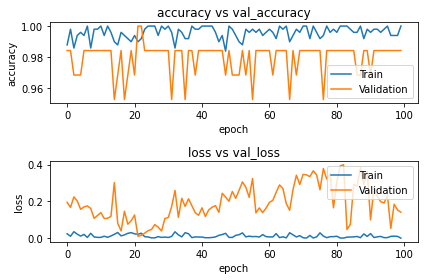

In [22]:
# Let's visualize the train/validation loss and accuracy wrt epochs

import matplotlib.pyplot as plt 
def plot(history):
    plt.figure(1) 
     # summarize history for accuracy  
 
    plt.subplot(211)  
    plt.plot(history.history['accuracy'])  
    plt.plot(history.history['val_accuracy'])  
    plt.title('accuracy vs val_accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('epoch')  
    plt.legend(['Train', 'Validation'], loc='lower right')  
 
     # summarize history for loss  
 
    plt.subplot(212)  
    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('loss vs val_loss')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.show()
 
# Finaly, let's call the plot function with the 'result' parameter 
 
plot(history)

**Few take aways :**
- From the Training and Validation Accuracy graph above, our model does not seem to be overfitted, which is great!;
- Our Training and Validation Loss graph above also indicates a good learning rate, which is amazing !

---

### **Prediction**
>Finally, let us test our model against more random samples from the test data !

2/2 [==============================] - 13s 6s/step


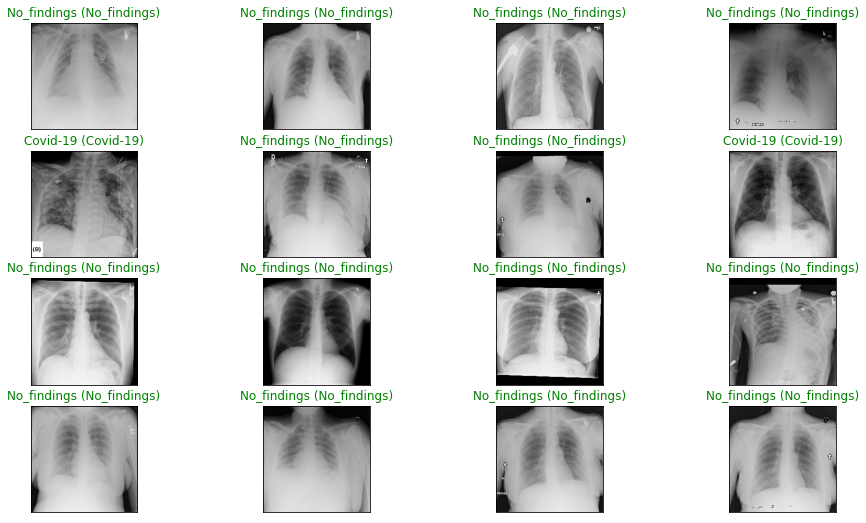

In [23]:
# Let's visualize some random test prediction.
def visualize_pred(y_pred):
# plot a random sample of test images, their predicted labels, and ground truth
    fig = plt.figure(figsize=(16, 9))
    for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[idx]))
        pred_idx = np.argmax(y_pred[idx])
        true_idx = np.argmax(y_test[idx])
        ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

visualize_pred(Model.predict(X_test))

### Confusion Matrix
> Please note that, **_0_ and _1_ values represent _Covid-19_ and _No_findigs_ respectively**  .

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred = Model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_test,axis = 1)
confusion_mtx = confusion_matrix(Y_true,Y_pred_classes)
f,ax = plt.subplots(figsize = (8,8))
sns.heatmap(confusion_mtx,annot=True,linewidths = 0.01,cmap="Greens",
            linecolor = "gray",fmt = ".2f",ax=ax
            )
plt.xlabel("predicted label")
plt.ylabel("True Label")
plt.title("confusion matrix")
plt.show()

> You can check the classification report below for more information !

In [ ]:
print(classification_report(y_test.argmax(axis=1),Y_pred_classes,  target_names= labels))

              precision    recall  f1-score   support

    Covid-19       1.00      0.81      0.90        16
 No_findings       0.94      1.00      0.97        46

    accuracy                           0.95        62
   macro avg       0.97      0.91      0.93        62
weighted avg       0.95      0.95      0.95        62



### Loading the model
> Here we're gonna load our best model trained befor, then make some predictions with it !

In [ ]:
my_model=keras.models.load_model("/gdrive/My Drive/NouredAminaVGG19m.h5")

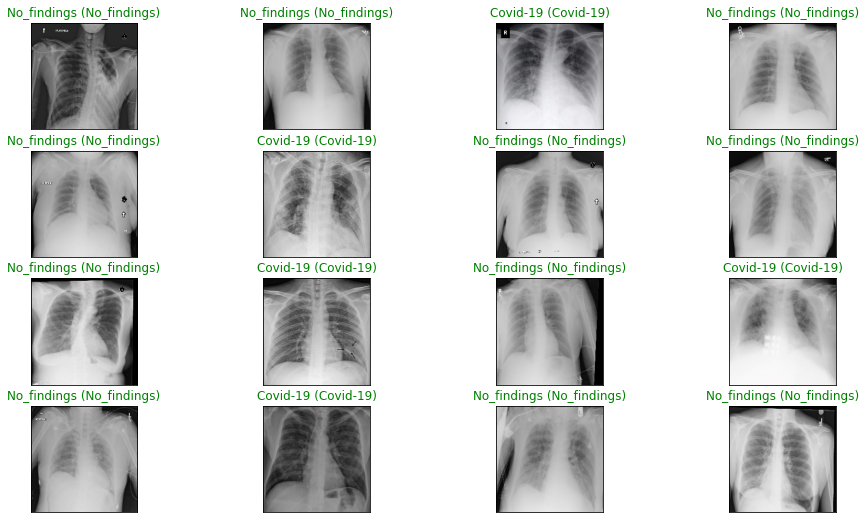

In [ ]:
# Let's visualize some random test prediction.
def visualize_pred(y_pred):
# plot a random sample of test images, their predicted labels, and ground truth
    fig = plt.figure(figsize=(16, 9))
    for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[idx]))
        pred_idx = np.argmax(y_pred[idx])
        true_idx = np.argmax(y_test[idx])
        ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

visualize_pred(my_model.predict(X_test))